In this file, we present the calculations analyzing the input data and analyzing the predictions of drug phenotype effects.

First we load in the files we made in notebook `1. curate_data.ipynb`

In [1]:
outfile='testdir/testfiles'
pfile='data_for_regression/multixcan_res_10027.txt'
dfile='data_for_regression/epa.txt'
yfile='data_for_regression/sider_y.txt'
usfile='data_for_regression/US.txt'
ufile='data_for_regression/U.txt'
test='test'
import sys
sys.path.append("code/")
import setup_data
P, Ymat, Yalign, US, U, UB, SB, VB, make_L = setup_data.setup(pfile, yfile, dfile, usfile, ufile, False)

usfile is  data_for_regression/US.txt
[0.01620408 0.02911992 0.04089331 0.0516165  0.0605785  0.06915536
 0.077376   0.08526528 0.09274951 0.09997383] 2


In [3]:
D = pd.read_csv(dfile,sep="\t",index_col=0)
D.head()

z = D.apply(lambda x: D.apply(lambda y: stats.spearmanr(x[~x.isnull() & ~y.isnull()], 
                                                    y[~x.isnull() & ~y.isnull()])[0]))


z.fillna(-2,inplace=True)
drugdo = set(US.index) & set(z.index)
usd = upper_tri(stats.spearmanr(US.loc[drugdo,:].transpose())[0])
dd = upper_tri(z.loc[drugdo, drugdo])
sel = dd > -2

In [18]:
stats.spearmanr(usd.values[np.where(sel)[0]],dd[sel])

SpearmanrResult(correlation=0.2106140392919811, pvalue=0.0)

## Results "3.1 Data curation and initial assessment"
SEt up the pairwise comparisons

In [2]:
from sklearn.metrics import pairwise_distances
from scipy import stats
from my_util import upper_tri

### Statistical test of similarity of *diseases* in terms of drugs associated vs in terms of genetic regulation
Loading in processed `Ymat` (side effects) and PhenomXcan `P` (phenotype genetic regulation)

In [10]:

jacc_disease_drug_sim = pd.DataFrame(pairwise_distances(Ymat.transpose().values==1,metric='jaccard'),
                       index=Ymat.columns,columns=Ymat.columns)


pcors = P.loc[:,Ymat.columns].corr(method='spearman')


pcors = upper_tri(pcors) #ttc.loc[ptstack.index, ptstack.index])


stats.spearmanr(upper_tri(jacc_disease_drug_sim),pcors)

SpearmanrResult(correlation=-0.11039370900920706, pvalue=2.0696576031480833e-53)

### Figure 1A

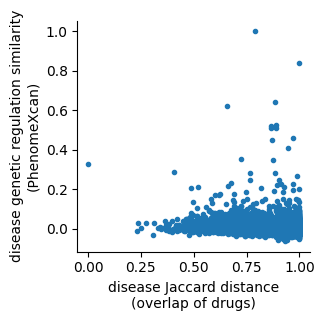

In [12]:
import matplotlib.pyplot as plt

f,ax = plt.subplots(1,figsize=(3,3))
ax.plot(upper_tri(jacc_disease_drug_sim),pcors ,'.')
ax.set_xlabel("disease Jaccard distance\n(overlap of drugs)")
ax.set_ylabel("disease genetic regulation similarity\n(PhenomeXcan)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
f.savefig("figs/disease_similarity_measures.png",bbox_inches='tight',dpi=300)

### Statistical test of similarity of *drugs* in terms of EPA endpoints vs phenotype side effects
Now:
- load in EPA
- get pairwise Spearman correlation of endpoints (dropping missing) = drug endpoint similarity
- get jaccard similarity of the drugs: how much do they share associated with phenotypes
- then compare these 2 measures of similarity: smaller Jaccard distance is associated with more correlated drug endpoints.

In [21]:


### load in EPA and make it into a matrix
epa = pd.read_table("intermediate_files/epa_compiled.txt.gz",sep="\t",index_col=0)
xstk = epa.loc[:,['cid','aenm','hit_pct']].set_index(['cid','aenm']).sort_index().transpose().stack('aenm')
#xstk = xstk.droplevel(0,0)
xstk.index = xstk.index.droplevel(0)
col = xstk.columns

def spea(x,y):
    sel = (x > -1) & (y>-1)
    return stats.spearmanr(x[sel], y[sel])[0]

spe = pd.DataFrame(pairwise_distances(xstk.transpose().fillna(-1) ,metric=spea),index=col,columns=col)

### load in side effects, again make it into a matrix
sider = pd.read_csv("input_data/meddra_all_se.tsv.gz",sep="\t",header=None)
sider['cid'] = sider[0].str.slice(4).map(int) ## get pubchem ID
sider_matched_filter = sider.loc[sider['cid'].isin(set(epa['cid'])) ,:] ## match to EPA pubchem ID
sider_matched_filter.columns = ['stitch_flat','stitch_stereo','UMLS_label', 'type','meddra','se_name','pubchem_cid']
pt = sider_matched_filter.loc[sider_matched_filter['type']=='PT',].drop_duplicates(['pubchem_cid','meddra']).copy()

pt['ae'] = 1
ptstack = pt.loc[:,['pubchem_cid','se_name','ae']].drop_duplicates(['pubchem_cid','se_name']).set_index(['pubchem_cid','se_name']).sort_index() #.unstack().shape
ptstack = ptstack.transpose().stack('se_name') ## make into matrix form
ptstack = ptstack.mask(pd.isnull(ptstack), other=0)
ptstack.index = ptstack.index.droplevel(0)
ptstack = ptstack.loc[ptstack.sum(axis=1) < 200,:] # removed anything very nonspecific

### 
drug_phesim = pd.DataFrame(pairwise_distances(pd.DataFrame(ptstack.transpose(),dtype=bool),metric='jaccard'),index=ptstack.columns,columns=ptstack.columns)
drug_phesim = upper_tri(drug_phesim.loc[spe.index, spe.index])
drug_epa_sim = upper_tri(spe)
x = drug_epa_sim.index.intersection(drug_phesim.index)
stats.spearmanr(drug_phesim.loc[x], drug_epa_sim.loc[x])


/share/pkg/python3/3.6_intel_pu3_2018.3.039/intelpython3/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


SpearmanrResult(correlation=-0.03373741128515219, pvalue=6.475781341553099e-24)

Linear regression analysis

In [59]:
def nna(x,y):
    return sum((x > -1) & (y > -1))
    #return stats.spearmanr(x[sel], y[sel])[0]
nnan = pd.DataFrame(pairwise_distances(xstk.transpose().fillna(-1),metric=nna),index=col,columns=col)
nnas = upper_tri(nnan.loc[spe.index, spe.index])
import statsmodels.api as sm
df = pd.DataFrame({'j':drug_phesim.loc[x],'num_nna':nnas.loc[x],'spe':drug_epa_sim.loc[x]})
df = sm.add_constant(df)
mod = sm.OLS(df['j'],df.drop('j',axis=1)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      j   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     118.7
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           3.24e-52
Time:                        21:17:52   Log-Likelihood:             1.1524e+05
No. Observations:               89298   AIC:                        -2.305e+05
Df Residuals:                   89295   BIC:                        -2.304e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9291      0.001   1653.840      0.000       0.928       0.930
num_nna     1.568e-05   2.05e-06      7.661      0.000    1.17e-05    1.97e-05
spe           -0.0234      0.002    -13.835      0.000      -0.027      -0.020
==============================================================================
Omnibus:                    25096.727   Durbin-Watson:                   1.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80776.347
Skew:                          -1.433   Prob(JB):                         0.00
Kurtosis:                       6.673   Cond. No.                     1.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
mod.pvalues

const      0.000000e+00
num_nna    1.861201e-14
spe        1.748472e-43
dtype: float64

## Results "3.2 Assessment of the model's predictive performance"

Here, we do analysis of the $W$ matrix and its predictions, from the results of `2. run_models.ipynb`.



### Figure 2A: Prediction distances
Load in the results of the held out drug analysis-- then compare to the nearest drug in terms of input distance (in $U_DS_D$).

Then just plot the values -- each point is one drug

In [41]:
### held out drug predictions 
leaveout = pd.read_csv("results/lo_pred_C.1.txt",sep="\t",index_col=0)
leaveout = leaveout.loc[Ymat.index.map(int), Ymat.columns]
leaveout.index = Ymat.index

### nearest drug in drug EPA reduced space
corr = US.transpose().corr(method='spearman') - np.eye(US.shape[0])
max_ix = corr.idxmax(axis=1)
nn_pred = Ymat.loc[max_ix,:]
nn_pred.index = Ymat.index

### get Jaccard distance (higher = further) from true data Ymat to these 2 types of predictions
from scipy.spatial import distance
jaccard_dist_nn = pd.concat((nn_pred, Ymat),axis=1).apply(lambda x: distance.jaccard(x[:nn_pred.shape[1]], 
                                                                                       x[nn_pred.shape[1]:]),axis=1)

jaccard_dist_lo = pd.concat((leaveout, Ymat),axis=1).apply(lambda x: distance.jaccard(x[:nn_pred.shape[1]], 
                                                                                       x[nn_pred.shape[1]:]),axis=1)

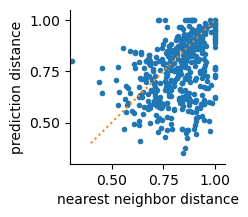

In [24]:
import matplotlib.pyplot as plt

f,ax = plt.subplots(1,figsize=(2,2))
ax.plot(jaccard_dist_nn,jaccard_dist_lo ,'.')
ax.plot([.4,1],[.4,1],':')
ax.set_xlim(.3,1.05)
ax.set_ylim(.3,1.05)
ax.set_xticks([.5,.75,1])
ax.set_yticks([.5,.75,1])
ax.set_xlabel("nearest neighbor distance")
ax.set_ylabel("prediction distance")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
f.savefig("nearest_neighbor_hold_outpredictions.pdf",bbox_inches='tight')

In [25]:
stats.ranksums(jaccard_dist_nn,jaccard_dist_lo )

RanksumsResult(statistic=6.481423496927003, pvalue=9.086123701294992e-11)

## Comparison to other work and AUC
See `3a_curate_galeano_drugvoyager.ipynb` for details on how results from Galeano 2020 and Drug Voyager (Oh 2017) were curated to match to the phenotypes and drugs in our analysis.

Compare predictions to Sider SE presence/absence

In [19]:
s8_match = pd.read_csv("evaluations/galeano_match_cid_ukb.txt",sep="\t",index_col=0)
s8_match.head()

s8_stack = s8_match.loc[:,['ukb','cid','PredictedScore']].sort_values('PredictedScore').drop_duplicates(['ukb','cid'],keep='last').set_index(['cid','ukb']).transpose().stack('ukb').fillna(0)
s8_stack.index = s8_stack.index.droplevel(0)
s8_stack.shape

se_mat = pd.read_csv("data_for_regression/sider_y.txt",sep="\t",index_col=0)
se_mat.columns = se_mat.columns.map(int)

drugboth = set(s8_stack.columns) & set(se_mat.columns.map(int))
disboth = set(s8_stack.index) & set(se_mat.index)


In [28]:
draph_pred = pd.read_table("results/lo_proba_C.1.txt",sep="\t",index_col=0)

### permuted W predictions example
red = pd.read_table("pred_1.txt",sep=",",index_col=0)
sred2 = pd.read_table("pred2_perm.txt",sep="\t",index_col=0)
sred2.columns = red.columns

In [ ]:
red = pd.read_table("pred_1.txt",sep=",",index_col=0)
red2 = pd.read_table("pred2.txt",sep="\t",index_col=0)

scr = pd.read_table("pred_3_scr.txt",sep=",",index_col=0)

In [ ]:
sum(

## Draphnet predictions (held out drugs)

In [29]:
sep_disboth = set(draph_pred.columns)  & set(se_mat.index)
len(sep_disboth)

197

In [30]:
sep_drugboth = set(draph_pred.index)  & set(se_mat.columns.map(int))
len(sep_drugboth)

421

In [31]:
double_drug = list(sep_drugboth & drugboth)
double_dis = list(sep_disboth & disboth)

In [39]:
len(double_drug)

215

In [40]:
len(double_dis)

155

In [34]:
from sklearn.metrics import roc_auc_score


In [35]:
galeano_v_sider = pd.concat(( s8_stack.loc[double_dis, double_drug].unstack().transpose(), 
                             se_mat.loc[double_dis,double_drug].unstack().transpose()),axis=1)# galeano':s8_stack.unstack().transpose(),
#                                  'sider':se_mat.unstack().transpose()})

galeano_v_sider.columns = ['galeano','sider']
roc_auc_score(galeano_v_sider['sider'], galeano_v_sider['galeano'])

0.5624101969065772

In [36]:
pred_v_sider = pd.concat((draph_pred.transpose().loc[double_dis, double_drug].unstack().transpose(),
    se_mat.loc[double_dis, double_drug].unstack().transpose()),axis=1)
pred_v_sider.columns = ['pred','sider']

roc_auc_score(pred_v_sider['sider'], pred_v_sider['pred'])

0.7446624878733044

In [44]:
nn_pred.head()

ukb,#Arthrosis,AV-block,Actinic keratosis,Anxiety disorders,Atrophic disorders of skin,Breast Cancer,Bronchitis,"Cancer code, self-reported: basal cell carcinoma","Cancer code, self-reported: lung cancer","Cancer code, self-reported: malignant melanoma",...,Rheumatoid Arthritis,STROKE,Schizophrenia,Sleep apnoea,Sleeping too much,Substance abuse,Systemic Lupus Erythematosus,"Thrombocytopenia, unspecified",Ulcer of oesophagus,Viral hepatitis
10113978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [45]:
nn_pred.index = nn_pred.index.map(int)

In [46]:
nnpred_v_sider = pd.concat((nn_pred.transpose().loc[double_dis, double_drug].unstack().transpose(),
    se_mat.loc[double_dis, double_drug].unstack().transpose()),axis=1)
nnpred_v_sider.columns = ['pred','sider']

roc_auc_score(nnpred_v_sider['sider'], nnpred_v_sider['pred'])

0.6000773374533491

In [37]:
spred_v_sider = pd.concat((sred2.transpose().loc[double_dis, double_drug].unstack().transpose(),
    se_mat.loc[double_dis, double_drug].unstack().transpose()),axis=1)
spred_v_sider.columns = ['pred','sider']

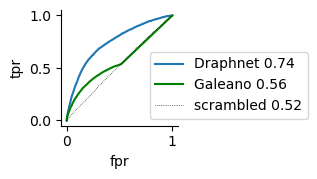

In [38]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = metrics.roc_curve(pred_v_sider['sider'], pred_v_sider['pred'], pos_label=1)
fprs, tprs, thresholds = metrics.roc_curve(spred_v_sider['sider'], spred_v_sider['pred'], pos_label=1)
fprg, tprg, thresholds = metrics.roc_curve(galeano_v_sider['sider'], galeano_v_sider['galeano'], pos_label=1)

#fprnn, tprnn, thresholds = metrics.roc_curve(nn_v_sider['sider'], nn_v_sider['pred'], pos_label=1)
f, ax = plt.subplots(1, figsize=(1.5,1.5))
ax.plot(fpr, tpr)
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(fprg, tprg,c='green')
ax.plot(fprs, tprs,":",c='k',linewidth=.5)

ax.legend(['Draphnet {:1.2f}'.format(roc_auc_score(pred_v_sider['sider'], pred_v_sider['pred'])),
            'Galeano {:1.2f}'.format(roc_auc_score(galeano_v_sider['sider'], galeano_v_sider['galeano'])),
           'scrambled {:1.2f}'.format(roc_auc_score(spred_v_sider['sider'], spred_v_sider['pred']))],bbox_to_anchor=[.7,.7]) #loc='outside right')

f.savefig("auc.pdf",bbox_inches='tight')

## Drug Voyager comparison
Get the drug-phenotype matches between both 

In [78]:
se_dv_match = pd.read_csv("evaluations/drugvoyager_match.txt",sep="\t",index_col=0)
se_dv_match.head()

se_dv_match['ae'] = 1
dv_stack = se_dv_match.loc[:,['ukb','cid','ae']].drop_duplicates().set_index(['cid','ukb']).transpose().stack('ukb').fillna(0)
dv_stack.index = dv_stack.index.droplevel(0)

dvs_drugboth = list(set(dv_stack.columns) & set(se_mat.columns.map(int)) & set(draph_pred.index))
dvs_disboth = list(set(dv_stack.index) & set(se_mat.index))
print("testing ", len(dvs_drugboth),'drug and ',len(dvs_disboth),'diseases')

testing  20 drug and  151 diseases


In [76]:
dv_v_sider = pd.concat(( dv_stack.loc[dvs_disboth, dvs_drugboth].unstack().transpose(), 
                             se_mat.loc[dvs_disboth,dvs_drugboth].unstack().transpose()),axis=1)# galeano':s8_stack.unstack().transpose(),
#                                  'sider':se_mat.unstack().transpose()})

dv_v_sider.columns = ['dv','sider']

roc_auc_score(dv_v_sider['sider'], dv_v_sider['dv'])

0.452822534212737

In [77]:
draph_v_s_dv = pd.concat(( 
                          draph_pred.transpose().loc[dvs_disboth,dvs_drugboth].unstack().transpose(), 
                            se_mat.loc[dvs_disboth,dvs_drugboth].unstack().transpose()),axis=1)# galeano':s8_stack.unstack().transpose(),
#                                  'sider':se_mat.unstack().transpose()})

draph_v_s_dv.columns = ['draph','sider']
from sklearn.metrics import roc_auc_score
roc_auc_score(draph_v_s_dv['sider'], draph_v_s_dv['draph'])

0.7498491609528252

## Offsides comparison
Offsides was processed to match with drugbank and pubchem identifiers, and phenotypes 

In [51]:
off_match = pd.read_csv("evaluations/offsides_processed.txt",sep="\t",index_col=0)

#o2 = off_match.loc[off_match['pubchem_cid'].isin(drugboth),:]
o2 = off_match.sort_values('PRR-2Err').drop_duplicates(['pubchem_cid','ukb'],keep='last').set_index(['pubchem_cid','ukb']).transpose().stack().fillna(0)

o2.index = o2.index.droplevel(0)

o_drugboth = set(off_match['pubchem_cid']) & set(s8_match['cid'])

o_disboth = set(off_match['ukb']) & set(s8_match['ukb'])

sep_o_drugboth = set(draph_pred.index)  & set(off_match['pubchem_cid'])
len(sep_o_drugboth)

sep_o_disboth = set(draph_pred.columns)  & set(off_match['ukb'])
len(sep_o_disboth)

o_double_drug = list(sep_o_drugboth & o_drugboth)
o_double_dis = list(sep_o_disboth & o_disboth)



In [53]:
len(o_double_drug)

193

In [54]:
len(o_double_dis)

155

In [13]:
galeano_v_offs = pd.concat(( s8_stack.loc[o_double_dis,o_double_drug].unstack(), 
                            o2.loc[o_double_dis,o_double_drug].unstack()),axis=1)# galeano':s8_stack.unstack().transpose(),
#                                  'sider':se_mat.unstack().transpose()})

galeano_v_offs.columns = ['galeano','offsides']

from sklearn.metrics import roc_auc_score
roc_auc_score(galeano_v_offs['offsides']>1, galeano_v_offs['galeano'])

0.5461471722750265

In [57]:
draph_v_offs = pd.concat(( 
                          draph_pred.transpose().loc[o_double_dis,o_double_drug].unstack().transpose(), 
                            o2.loc[o_double_dis,o_double_drug].unstack()),axis=1)# galeano':s8_stack.unstack().transpose(),
#                                  'sider':se_mat.unstack().transpose()})

draph_v_offs.columns = ['draph','offsides']
from sklearn.metrics import roc_auc_score
roc_auc_score(draph_v_offs['offsides']>1, draph_v_offs['draph'])

0.549688430859437

In [58]:
stats.spearmanr(galeano_v_offs['offsides'], galeano_v_offs['galeano'])

SpearmanrResult(correlation=0.12520853850905594, pvalue=8.458621208023617e-105)

In [44]:
stats.spearmanr(draph_v_offs['offsides'], draph_v_offs['draph'])

SpearmanrResult(correlation=0.14004873288590144, pvalue=7.080738459440886e-131)

In [60]:
stats.spearmanr(draph_v_offs.loc[galeano_v_offs.index,'draph'], galeano_v_offs['galeano'])

SpearmanrResult(correlation=0.24423878906107874, pvalue=0.0)

### Predictions discussed in this section
Obtain predictions: model was fit as $V_P \otimes U_DS_D \dot W_{DP} = Y $ so multiplying these together gives predictions (without intercept)
- $ U_DS_D$ reduced drug endpoint space
- $ U_DS_DW_{DP}$ mapping drug endpoints to projected effects on reduced phenome space
- $ U_DS_DW_{DP}V_P$ full predictions

In [64]:
names = pd.read_table("input_data/pubchem_names",header=None)
names[0] = names[0].map(str)
id2name = names.set_index(0).transpose().loc[1,:].to_dict()
name2id = names.set_index(1).transpose().loc[0,:].to_dict()

result_files = 'results/indications'
W = pd.read_table(result_files+ "_W.txt",index_col=0)
U_DS_DdotW = US.iloc[:,:W.shape[0]].dot(W).rename(id2name)

mod_red = pickle.load(open(result_files + '_lr.pkl','rb'))
VP = pd.read_table(result_files + '_VB.txt',index_col=0)

### predictions = $ U_DS_DW_{DP}V_P$ + intercepts
pred_red = U_DS_DdotW @ VP.transpose() + mod_red.intercept_[0]

pred_red.to_csv("results/indication_predictions.txt",sep="\t")

ModuleNotFoundError: No module named 'sklearn.linear_model.logistic'

In [65]:
pred_red = pd.read_csv("../indication_predictions.txt",sep="\t",index_col=0)

In [13]:
pred_red.head()

,pubchem_cid,Diagnoses - main ICD10: N17 Acute renal failure,Mood swings,Diagnoses - main ICD10: L43 Lichen planus,"Non-cancer illness code, self-reported: spinal cord disorder",Heart failure,"Non-cancer illness code, self-reported: heart arrhythmia",Diagnoses - main ICD10: R55 Syncope and collapse,Diseases of the genitourinary system,Conduction disorders,...,Myocardial infarction,Diagnoses - main ICD10: I61 Intracerebral haemorrhage,Diagnoses - main ICD10: N18 Chronic renal failure,Diagnoses - main ICD10: K20 Oesophagitis,"Non-cancer illness code, self-reported: depression",Diagnoses - main ICD10: R51 Headache,"Non-cancer illness code, self-reported: angina","Non-cancer illness code, self-reported: glaucoma","Cancer code, self-reported: non-hodgkins lymphoma","Non-cancer illness code, self-reported: hepatitis"
gamma-Aminobutyric acid,119,0.294328,0.327951,0.341806,0.343957,0.233357,0.304011,0.390795,0.318168,0.287722,...,0.410207,0.288261,0.270697,0.226072,0.252930,0.306913,0.376683,0.301767,0.312231,0.498478
Benzyl Alcohol,244,0.005458,0.064737,0.113486,0.141467,0.045761,0.005359,0.052809,0.006150,0.014374,...,0.131359,0.186764,0.154172,0.024260,0.204432,0.549059,0.186710,0.008194,0.032630,0.022977
Betaine,247,0.105486,0.151995,0.212605,0.283052,0.406506,0.268299,0.170826,0.152403,0.141320,...,0.474772,0.242387,0.170300,0.393698,0.511525,0.143558,0.468374,0.265767,0.115648,0.095249
Citric Acid,311,0.005249,0.004059,0.005787,0.026911,0.028742,0.031716,0.005505,0.006111,0.001612,...,0.066114,0.010306,0.935248,0.350296,0.015830,0.087222,0.079853,0.004439,0.045056,0.031193
Salicylic Acid,338,0.031381,0.287341,0.125535,0.037588,0.062592,0.037064,0.025568,0.019631,0.328724,...,0.007850,0.061228,0.153633,0.009251,0.807299,0.504674,0.105590,0.521810,0.688065,0.170727


In [66]:
Ymat_indications = pd.read_csv("data_for_regression/all_disease_indication_151x413.txt",sep="\t",index_col=0).rename(columns=id2name)
Ymat_indications.head()

,gamma-Aminobutyric acid,Benzyl Alcohol,Betaine,Citric Acid,Salicylic Acid,Aminocaproic acid,Lactic Acid,Dimethyl Sulfoxide,Dopamine,Ethanolamine,...,Ethionamide,Prucalopride,Dasatinib,Vandetanib,Tolcapone,Acipimox,"5-chloro-N-({2-oxo-3-[4-(3-oxomorpholin-4-yl)phenyl]-1,3-oxazolidin-5-yl}methyl)thiophene-2-carboxamide",Everolimus,Pazopanib,Carfilzomib
se_name,,,,,,,,,,,,,,,,,,,,,
#Arthrosis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV-block,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Actinic keratosis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anxiety disorders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Breast Cancer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
pred_red_match = pred_red.loc[set(Ymat_indications.columns) & set(pred_red.index),:]

Ymat_indications = Ymat_indications.loc[pred_red_match.columns,set(Ymat_indications.columns) & set(pred_red_match.index)].transpose()


pred_red_match.loc[Ymat_indications['Eczema']==0,'Eczema'].sort_values()

Disulfiram           -76.384160
Clotrimazole         -72.838426
Loratadine           -59.554425
Raloxifene           -58.712214
Carfilzomib          -58.065162
                        ...    
Sotalol                0.144657
Nepafenac              0.182960
Vecuronium bromide     0.338733
Metipranolol           1.162165
Fludrocortisone        1.602817
Name: Eczema, Length: 405, dtype: float64

In [75]:
pred_red_match.loc['Fludrocortisone',:].sort_values().tail(20)

Non-cancer illness code, self-reported: osteoarthritis                    0.494611
Diagnoses - main ICD10: R51 Headache                                      0.622087
Cancer code, self-reported: non-hodgkins lymphoma                         0.650266
Diagnoses - main ICD10: N80 Endometriosis                                 0.730521
Otitis externa                                                            0.730555
Non-cancer illness code, self-reported: hayfever/allergic rhinitis        0.734709
Non-cancer illness code, self-reported: anaemia                           0.737162
Non-cancer illness code, self-reported: asthma                            0.765427
Non-cancer illness code, self-reported: gout                              0.790871
Non-cancer illness code, self-reported: arthritis (nos)                   0.799777
Diagnoses - main ICD10: L43 Lichen planus                                 0.806860
Non-cancer illness code, self-reported: psoriasis                         0.823023
Ecze

In [18]:
Ymat_indications.loc[Ymat_indications['Eczema']==1,'Eczema'].sort_values()

Lidocaine                  1.0
Triamcinolone acetonide    1.0
Name: Eczema, dtype: float64

In [16]:
pred_red_match = pred_red.loc[set(Ymat_indications.columns) & set(pred_red.index),:]

Ymat_indications = Ymat_indications.loc[pred_red_match.drop('pubchem_cid',axis=1).columns,set(Ymat_indications.columns) & set(pred_red_match.index)].transpose()


pred_red_match.loc[Ymat_indications['Eczema']==0,'Eczema'].sort_values()

/tmp/ipykernel_988389/3426685901.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  pred_red_match = pred_red.loc[set(Ymat_indications.columns) & set(pred_red.index),:]
/tmp/ipykernel_988389/3426685901.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  Ymat_indications = Ymat_indications.loc[pred_red_match.drop('pubchem_cid',axis=1).columns,set(Ymat_indications.columns) & set(pred_red_match.index)].transpose()


Disulfiram            6.710900e-34
Clotrimazole          2.326341e-32
Hexachlorophene       3.839287e-28
Loratadine            1.367231e-26
Raloxifene            3.174020e-26
                          ...     
Sotalol               5.361014e-01
Nepafenac             5.456129e-01
Vecuronium bromide    5.838828e-01
Metipranolol          7.617259e-01
Fludrocortisone       8.324117e-01
Name: Eczema, Length: 411, dtype: float64

In [69]:
Ymat_indications.loc['Fludrocortisone',:].sort_values().tail(10)

Diagnoses - main ICD10: R52 Pain, not elsewhere classified     0.0
Non-cancer illness code, self-reported: atrial fibrillation    0.0
Myalgia                                                        0.0
Ulcer of oesophagus                                            0.0
Diseases of the nervous system                                 0.0
Diagnoses - main ICD10: R35 Polyuria                           0.0
Diagnoses - main ICD10: G47 Sleep disorders                    0.0
Non-cancer illness code, self-reported: hepatitis              0.0
Breast Cancer                                                  1.0
Neoplasms                                                      1.0
Name: Fludrocortisone, dtype: float64

In [79]:
glaucoma = 'Non-cancer illness code, self-reported: glaucoma'
pred_red_match.loc[Ymat_indications[glaucoma]==0,glaucoma].sort_values()

Troglitazone       -34.852543
Nitazoxanide       -28.334991
Nisoldipine        -28.319596
Mitotane           -26.543275
Clotrimazole       -26.293179
                      ...    
Felbamate            0.746012
Metyrapone           0.999977
Isoproterenol        1.373527
Chlorthalidone       1.533764
Methyclothiazide     2.193702
Name: Non-cancer illness code, self-reported: glaucoma, Length: 401, dtype: float64